In [ ]:
# %pip install --upgrade openai
# %pip install fastparquet
# %pip install rapidfuzz

## Import libraries

In [ ]:
import os
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path
# from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
from openai import OpenAI
from rapidfuzz import fuzz
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

## Set OpenAI API key

In [ ]:
# Set your API key
mykey = ""
client = OpenAI(api_key = mykey)

## Read JUSTICE dataset for deliberation of cases

In [ ]:
# Load the JSON data
with open('oyez.json', 'r') as file:
    data = json.load(file)

# Use pandas.json_normalize to flatten the JSON
df = pd.json_normalize(
    data,
    sep='_',  # Use an underscore (_) to flatten nested keys
)


In [ ]:
df.columns

Index(['ID', 'name', 'href', 'view_count', 'docket_number',
       'additional_docket_numbers', 'manner_of_jurisdiction', 'first_party',
       'second_party', 'timeline', 'lower_court', 'facts_of_the_case',
       'question', 'conclusion', 'advocates', 'oral_argument_audio',
       'decisions', 'first_party_label', 'second_party_label', 'heard_by',
       'term', 'location', 'opinion_announcement', 'description',
       'written_opinion', 'related_cases', 'justia_url', 'argument2_url',
       'citation_volume', 'citation_page', 'citation_year', 'citation_href',
       'decided_by_ID', 'decided_by_name', 'decided_by_href',
       'decided_by_view_count', 'decided_by_members', 'decided_by_court_start',
       'decided_by_images', 'decided_by_identifier', 'lower_court_ID',
       'lower_court_name', 'lower_court_href', 'location_latitude',
       'location_longitude', 'location_name', 'location_street',
       'location_city', 'location_province', 'location_postal_code',
       'location

In [ ]:
norm_cols = ["decisions"]

for col in norm_cols:
    # Explode columns
    df_exploded = df.explode([col])

    # Normalize the 'decided_by_members' column
    norm = pd.json_normalize(df_exploded[col])
    norm.columns = [f"dec_{c}" for c in norm.columns]

    # Merge the normalized data with the exploded DataFrame
    df_combined = pd.concat([df_exploded.drop(columns=[col]).reset_index(drop=True), norm], axis=1)
    df = pd.concat([df_combined.reset_index(drop=True)], axis=1)



In [ ]:
df_exploded = df.explode(['dec_votes'])
df_judges = pd.json_normalize(df_exploded['dec_votes'])
df_judges["ID"] = df_exploded["ID"].values
cols_to_drop = ['joining', 'href', 'member.href', 'member.view_count', 'member.roles', 'member.thumbnail.id', 'member.thumbnail.mime',
                'member.thumbnail.size', 'member.thumbnail.href', 'member.length_of_service']
df_judges = df_judges.drop(cols_to_drop, axis=1)

In [ ]:
cols_to_drop = ['advocates', 'oral_argument_audio', 'href', 'view_count', 'additional_docket_numbers', 'lower_court', 'citation',
                'location', 'opinion_announcement', 'written_opinion', 'related_cases', 'justia_url', 'argument2_url', 'manner_of_jurisdiction',
                'first_party_label', 'second_party_label', 'heard_by', 'term', 'location', 'opinion_announcement', 'description',
                'citation_volume', 'citation_page', 'citation_year', 'citation_href', 'decided_by_href', 'decided_by_view_count',
                'decided_by_court_start', 'decided_by_images', 'lower_court_ID', 'lower_court_name', 'lower_court_href', 'location_latitude',
                'location_longitude', 'location_name', 'location_street', 'location_city', 'location_province', 'location_postal_code',
                'location_province_name', 'decided_by_ID', 'decided_by_name', 'decided_by_members', 'decided_by_identifier', 'decided_by',
                'timeline', 'dec_description', 'dec_votes']
df = df.drop(cols_to_drop, axis=1)


In [ ]:
df = df.fillna(value = np.nan)
df = df.replace('', np.nan)
df = df.replace(' ', np.nan)
df = df.dropna(subset=['facts_of_the_case', 'question', 'conclusion'])

df_judges = df_judges.fillna(value = np.nan)
# df_judges = df_judges.lstrip()
# df_judges = df_judges.rstrip()
df_judges = df_judges.replace('', np.nan)
df_judges = df_judges.replace('none', np.nan)
df_judges = df_judges.dropna(subset=["vote", "seniority", "member.ID", "member.name", "member.last_name", "member.identifier"], how='any')

# Keep rows in df only if the same ID exists in df_judges
df = df[df["ID"].isin(df_judges["ID"])]


In [ ]:
df.isna().sum()

ID                               0
name                             0
docket_number                    0
first_party                      1
second_party                     1
facts_of_the_case                0
question                         0
conclusion                       0
dec_majority_vote                0
dec_minority_vote                0
dec_winning_party              937
dec_disposition                 77
dec_decision_type                6
dec_unconstitutionality          0
dec_alteration_of_precedent      0
dtype: int64

In [ ]:
df_judges.isna().sum()

vote                     0
opinion_type         55474
seniority                0
ideology                 0
member.ID                0
member.name              0
member.last_name         0
member.identifier        0
ID                       0
dtype: int64

#### Do not run again, results saved to file.

In [ ]:
# gpt_ver = "gpt-4o-mini-2024-07-18"

# # Define the function to get judge information
# def get_judge_info(judge_name: str, gpt_ver: str) -> str:
#     system_message = "Browse a name-specific Wikipedia page and give a response in 5 lines."
#     user_message = f"For US Supreme Court Justice {judge_name}, summarize their legal philosophy."

#     # Use the OpenAI API to get the completion
#     response = client.chat.completions.create(
#         model=gpt_ver,
#         messages=[
#             {"role": "system", "content": system_message},
#             {"role": "user", "content": user_message}
#         ],
#         temperature=0.5,  # Adjust for creativity
#         max_tokens=600,  # Token limit
#     )

#     # Return the content of the response
#     return (response.choices[0].message.content.encode('utf-8').decode('utf-8'))


# # Get unique names of judges
# unique_names = list(df_judges["member.identifier"].unique())

# # Initialize the personas dictionary
# personas = {}

# # Populate the personas dictionary by iterating over unique names
# for name in unique_names:
#     personas[name] = get_judge_info(name, gpt_ver)

# # Map the personas dictionary to the 'member.persona' column
# df_judges["member.persona"] = df_judges["member.identifier"].map(personas)

# # Fill missing values with a default message if needed
# df_judges["member.persona"] = df_judges["member.persona"].fillna(value=np.nan)
# df_judges.to_parquet(f"preprocessed_judges_with_personas.parquet", engine="fastparquet", index=False)
# print(f"Parquet file successfully written for preprocessed_judges_with_personas.")


In [ ]:
df_judges

,vote,opinion_type,seniority,ideology,member.ID,member.name,member.last_name,member.identifier,ID
9,majority,NaN,2.0,-7.602,15107.0,William O. Douglas,Douglas,william_o_douglas,50601
10,majority,NaN,4.0,0.109,15043.0,Potter Stewart,Stewart,potter_stewart,50601
11,majority,majority,6.0,-1.072,15104.0,Thurgood Marshall,Marshall,thurgood_marshall,50601
12,majority,NaN,3.0,-1.174,15140.0,"William J. Brennan, Jr.",Brennan,william_j_brennan_jr,50601
13,majority,NaN,5.0,0.664,15071.0,Byron R. White,White,byron_r_white,50601
...,...,...,...,...,...,...,...,...,...
77773,majority,NaN,8.0,0.000,17766.0,Brett M. Kavanaugh,Kavanaugh,brett_m_kavanaugh,63335
77774,minority,dissent,7.0,0.000,62836.0,Neil Gorsuch,Gorsuch,neil_gorsuch,63335
77775,minority,NaN,2.0,0.000,15100.0,Clarence Thomas,Thomas,clarence_thomas,63335
77776,minority,NaN,6.0,0.000,15094.0,Elena Kagan,Kagan,elena_kagan,63335


In [ ]:
df

,ID,name,docket_number,first_party,second_party,facts_of_the_case,question,conclusion,dec_majority_vote,dec_minority_vote,dec_winning_party,dec_disposition,dec_decision_type,dec_unconstitutionality,dec_alteration_of_precedent
12,50606,Roe v. Wade,70-18,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",<p>Does the Constitution recognize a woman's r...,<p>Inherent in the Due Process Clause of the F...,7.0,2.0,Jane Roe,reversed,majority opinion,True,False
21,50613,Stanley v. Illinois,70-5014,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,<p>Does the Illinois statutory scheme that ass...,"<p>Yes. Justice Byron R. White, writing for a...",5.0,2.0,Stanley,reversed/remanded,majority opinion,True,False
22,50613,Stanley v. Illinois,70-5014,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,<p>Does the Illinois statutory scheme that ass...,"<p>Yes. Justice Byron R. White, writing for a...",5.0,2.0,Stanley,reversed/remanded,majority opinion,True,False
26,50623,Giglio v. United States,70-29,John Giglio,United States,<p>John Giglio was convicted of passing forged...,<p>Is the prosecution’s failure to disclose a ...,"<p>Yes. Chief Justice Warren E. Burger, writi...",7.0,0.0,Giglio,reversed/remanded,majority opinion,False,False
37,50632,Reed v. Reed,70-4,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",<p>Did the Idaho Probate Code violate the Equa...,"<p>In a unanimous decision, the Court held tha...",7.0,0.0,Sally Reed,reversed/remanded,majority opinion,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8903,63324,United States v. Palomar-Santiago,20-437,United States,Refugio Palomar-Santiago,"<p>Refugio Palomar-Santiago, a Mexican nationa...",<p>Is a defendant who has been charged with un...,<p>A defendant seeking dismissal of a prior de...,9.0,0.0,United States,reversed/remanded,majority opinion,False,False
8904,63323,Terry v. United States,20-5904,Tarahrick Terry,United States,<p>Tarahrick Terry pleaded guilty to one count...,"<p>Do pre-August 3, 2010, crack offenders sent...",<p>Crack offenders sentenced under 21 U.S.C. §...,9.0,0.0,United States,affirmed,majority opinion,False,False
8906,63331,United States v. Cooley,19-1414,United States,Joshua James Cooley,<p>Joshua James Cooley was parked in his picku...,<p>May a police officer for a Native American ...,<p>A tribal police officer has the authority t...,9.0,0.0,United States,vacated/remanded,majority opinion,False,False
8907,63332,Florida v. Georgia,142-orig,Florida,Georgia,<p>This is an ongoing case of original jurisdi...,<p>Is Florida is entitled to equitable apporti...,<p>Florida failed to establish that Georgia’s ...,9.0,0.0,Georgia,none,majority opinion,False,False


In [ ]:
pd.Series.to_json(df.loc[12, ['ID','first_party','second_party','facts_of_the_case','question']])

'{"ID":50606,"first_party":"Jane Roe","second_party":"Henry Wade","facts_of_the_case":"<p>In 1970, Jane Roe (a fictional name used in court documents to protect the plaintiff\\u2019s identity) filed a lawsuit against Henry Wade, the district attorney of Dallas County, Texas, where she resided, challenging a Texas law making abortion illegal except by a doctor\\u2019s orders to save a woman\\u2019s life. In her lawsuit, Roe alleged that the state laws were unconstitutionally vague and abridged her right of personal privacy, protected by the First, Fourth, Fifth, Ninth, and Fourteenth Amendments.<\\/p>\\n","question":"<p>Does the Constitution recognize a woman\'s right to terminate her pregnancy by abortion?<\\/p>\\n"}'

## Call GPT and Create SC Simulation

In [ ]:
# Make API calls

def simulation(case_content:str, judges:int, gpt_ver:str, style:str, input_prompts:dict, output_prompts:dict, case_id:int, file_path:str, persona:bool = False):

    # Create a list to store all responses
    all_responses = [{
        "Phase": "Case Facts",
        "Judge": 'None',
        "CaseID": case_id,
        "Response": case_content
    }]

    ind_eval_responses = {}
    review_responses = {}
    verdict_responses = {}
    phases = 4

    for phase in range(phases):
        if phase == 0:
            if style == 'parallel':
                asst_msg = {"role": "assistant", "content": ""}
            else:
                asst_msg = {"role": "assistant", "content": str(ind_eval_responses)}

            for judge in range(judges):
                # Make the API call
                ind_eval_responses[judge] = client.chat.completions.create(
                    model=gpt_ver,
                    messages=[
                        {"role": "system", "content": input_prompts['system_message'] + output_prompts['ind_eval_output']},
                        {"role": "user", "content": case_content + f"As Judge {judge}, " + input_prompts['ind_eval_cmd']},
                        asst_msg
                    ],
                    temperature=1,
                    max_tokens=900,
                )
                # Extract and store response
                response_content = ind_eval_responses[judge].choices[0].message.content.encode('utf-8').decode('utf-8')
                all_responses.append({
                    "Phase": "Independent Evaluation",
                    "Judge": judge,
                    "CaseID": case_id,
                    "Response": response_content
                })

        if phase == 1:
            if style == 'parallel':
                asst_msg = {"role": "assistant", "content": str(ind_eval_responses)}
            else:
                asst_msg = {"role": "assistant", "content": str(ind_eval_responses) + "\n" + str(review_responses)}

            for judge in range(judges):
                # Make the API call
                review_responses[judge] = client.chat.completions.create(
                    model=gpt_ver,
                    messages=[
                        {"role": "system", "content": input_prompts['system_message'] + output_prompts['review_output']},
                        {"role": "user", "content": case_content + f"As Judge {judge}, " + input_prompts['review_cmd']},
                        asst_msg
                    ],
                    temperature=1,
                    max_tokens=500,
                )
                # Extract and store response
                response_content = review_responses[judge].choices[0].message.content.encode('utf-8').decode('utf-8')
                all_responses.append({
                    "Phase": "Review",
                    "Judge": judge,
                    "CaseID": case_id,
                    "Response": response_content
                })

        if phase == 2:
            if style == 'parallel':
                asst_msg = {"role": "assistant", "content": str(review_responses)}
            else:
                asst_msg = {"role": "assistant", "content": str(ind_eval_responses) + "\n" + str(review_responses) + "\n" + str(verdict_responses)}

            for judge in range(judges):
                # Make the API call
                verdict_responses[judge] = client.chat.completions.create(
                    model=gpt_ver,
                    messages=[
                        {"role": "system", "content": input_prompts['system_message'] + output_prompts['verdict_output']},
                        {"role": "user", "content": case_content + f"As Judge {judge} , " + input_prompts['verdict_cmd']},
                        asst_msg
                    ],
                    temperature=1,
                    max_tokens=500,
                )
                # Extract and store response
                response_content = verdict_responses[judge].choices[0].message.content.encode('utf-8').decode('utf-8')
                all_responses.append({
                    "Phase": "Verdict",
                    "Judge": judge,
                    "CaseID": case_id,
                    "Response": response_content
                })

        if phase == 3:
            if style == 'parallel':
                asst_msg = {"role": "assistant", "content": str(verdict_responses)}
            else:
                asst_msg = {"role": "assistant", "content": str(ind_eval_responses) + "\n" + str(review_responses) + "\n" + str(verdict_responses)}

            final_response = client.chat.completions.create(
                model=gpt_ver,
                messages=[
                    {"role": "system", "content": input_prompts['system_message'] + output_prompts['maj_output']},
                    {"role": "user", "content": case_content + f"On behalf of the entire Supreme Court Panel, " + input_prompts['maj_cmd']},
                    asst_msg
                ],
                temperature=1,
                max_tokens=900,
            )
            # Extract and store final response
            response_content = final_response.choices[0].message.content.encode('utf-8').decode('utf-8')
            all_responses.append({
                "Phase": "Final Decision",
                "Judge": "All",
                "CaseID": case_id,
                "Response": response_content
            })

    # Convert all responses to a single DataFrame
    df_responses = pd.DataFrame(all_responses)
    # Preprocess DataFrame for Parquet
    df_responses = df_responses.map(lambda x: str(x) if isinstance(x, (list, dict)) else x)  # Flatten unsupported types
    df_responses = df_responses.fillna("")  # Handle NaN values
    df_responses = df_responses.astype({
        "Phase": "string",
        "Judge": "string",
        "CaseID": "int",
        "Response": "string"
    })
    df_responses.head()
    # Save DataFrame to Parquet using fastparquet
    try:
        df_responses.to_parquet(f"{file_path}{case_id}.parquet", engine="fastparquet", index=False)
        print(f"Parquet file successfully written for CaseID {case_id}.")
    except Exception as e:
        print(f"Error writing parquet file: {e}")


In [ ]:
# Define Parallel Prompts

parallel_prompts:dict = {}

parallel_prompts['ind_eval_cmd'] = f"""
perform an independent evaluation following these steps:
<Step>
    <Title>Independent Evaluation</Title>
    <Details>
        <Detail>Analyze the facts of the case.</Detail>
        <Detail>Deliver their independent opinion with detailed reasoning.</Detail>
    </Details>
</Step>
"""

parallel_prompts['review_cmd'] = f"""
review and evaluate the reasoning of other judges provided by following these steps:
<Step>
    <Title>Deliberation</Title>
    <Details>
        <Detail>Judge will review and evaluate the reasoning of others.</Detail>
        <Detail>
            Each judge will either <Action>concur</Action> (agree) or <Action>dissent</Action> (disagree) with their peers,
            providing reasons for their agreement or disagreement.
        </Detail>
        <Detail>Judges are allowed to revise their initial opinions during this process.</Detail>
    </Details>
</Step>
"""

parallel_prompts['verdict_cmd'] = f"""
provide your verdict by following these steps:
<Step>
    <Title>Your Verdict</Title>
    <Details>
        <Detail>Each judge will deliver a final verdict based on previous reviews, siding with either the <Verdict>First Party</Verdict> or <Verdict>Second Party<Verdict> in the case.</Detail>
    </Details>
</Step>
"""

parallel_prompts['maj_cmd'] = f"""
As the <USSupremeCourtPanel>, mention the <WinningParty>First Party or Second Party</WinningParty>:
<Step>
    <Title>Final Verdict</Title>
    <Details>
        <Detail>Check the verdict of each of the three judges.</Detail>
        <Detail>The majority of the verdicts will be the final verdict, siding with either the <Verdict>First Party</Verdict> or the <Verdict>Second Party<Verdict> in the case.</Detail>
        <Detail>The majority vote will determine the winning party.</Detail>
    </Details>
</Step>
<Step>
    <Title>Case Conclusion</Title>
    <Details>
        <Detail>Summarize the decision and reasoning in a brief conclusion based on the final verdict.</Detail>
    </Details>
</Step>
"""




In [ ]:
# Define Output Prompts

output_prompts:dict = {}

output_prompts['ind_eval_output'] = """
Provide the following details in XML tags: Analysis, Opinion.
"""

output_prompts['review_output'] = """
Provide the following details in XML tags: Review, Action.
"""

output_prompts['verdict_output'] = """
Provide the following details in XML tags: Verdict.
"""

output_prompts['maj_output'] = f"""
Provide the following details in XML tags: MajorityVerdict, MinorityVerdict, Conclusion, WinningParty.
Always keep WinningParty in the last line of your response.
Always mention the name of the WinningParty instead of first party or second party.
"""



In [ ]:
# Define Chained Prompts

chained_prompts:dict = {}

chained_prompts['ind_eval_cmd'] = f"""
based on the previous <Analysis> and <Opinion>, perform an evaluation following these steps:
<Step>
    <Title>Independent Evaluation</Title>
    <Details>
        <Detail>Judge will analyze the facts of the case.</Detail>
        <Detail>Each judge will either <Action>concur</Action> (agree) or <Action>dissent</Action> (disagree) with their peers,
            providing reasons for their agreement or disagreement.</Detail>
    </Details>
</Step>
"""

chained_prompts['review_cmd'] = f"""
based on the previous round of evaluation, review the reasoning of other judges provided by following these steps:
<Step>
    <Title>Deliberation</Title>
    <Details>
        <Detail>Judge will review and evaluate the reasoning of others.</Detail>
        <Detail>Judges will revise their initial opinion or not.</Detail>
        <Detail>
            Each judge will again either <Action>concur</Action> (agree) or <Action>dissent</Action> (disagree) with their peers based on the revised opinion,
            providing reasons for their agreement or disagreement.
        </Detail>
    </Details>
</Step>
"""

chained_prompts['verdict_cmd'] = f"""
provide your verdict by following these steps:
<Step>
    <Title>Your Verdict</Title>
    <Details>
        <Detail>Each judge will deliver a final verdict based on previous reviews, siding with either the <Verdict>First Party</Verdict> or <Verdict>Second Party<Verdict> in the case.</Detail>
    </Details>
</Step>
"""

chained_prompts['maj_cmd'] = f"""
As the <USSupremeCourtPanel>, mention the <WinningParty>First Party or Second Party</WinningParty>:
<Step>
    <Title>Final Verdict</Title>
    <Details>
        <Detail>Check the verdict of each of the three judges.</Detail>
        <Detail>The majority of the verdicts will be the final verdict, siding with either the <Verdict>First Party</Verdict> or the <Verdict>Second Party<Verdict> in the case.</Detail>
        <Detail>The majority vote will determine the winning party.</Detail>
    </Details>
</Step>
<Step>
    <Title>Case Conclusion</Title>
    <Details>
        <Detail>Summarize the decision and reasoning in a brief conclusion based on the final verdict.</Detail>
    </Details>
</Step>
"""


#### Configurations

In [ ]:
# Random Sampling
df_sample = df.sample(n=2, random_state=42)
df_sample = df_sample.reset_index()
global num_judges

In [ ]:
# # Configuration 1

# num_judges = 1
# gpt_ver = "gpt-4o-mini-2024-07-18"
# file_path = "config_1_results/200_sample_output_"
# style = 'parallel'
# input_prompts = parallel_prompts
# persona = False

In [ ]:
# # Configuration 2

# num_judges = 9
# gpt_ver = "gpt-4o-mini-2024-07-18"
# file_path = "config_2_results/200_sample_output_"
# style = 'parallel'
# input_prompts = parallel_prompts
# persona = False

In [ ]:
# # Configuration 3

# num_judges = 1
# gpt_ver = "gpt-4o-mini-2024-07-18"
# file_path = "config_3_results/200_sample_output_"
# style = 'chained'
# input_prompts = chained_prompts
# persona = False

In [ ]:
# # Configuration 4

# num_judges = 9
# gpt_ver = "gpt-4o-mini-2024-07-18"
# file_path = "config_4_results/200_sample_output_"
# style = 'chained'
# input_prompts = chained_prompts
# persona = False

In [ ]:
# Configuration 5

num_judges = 0
gpt_ver = "gpt-4o-mini-2024-07-18"
file_path = "results_try/2_sample_output_"
style = 'parallel'
input_prompts = parallel_prompts
persona = True

In [ ]:
# # Configuration 6

# num_judges = 0
# gpt_ver = "gpt-4o-mini-2024-07-18"
# file_path = "config_6_results/200_sample_output_"
# style = 'chained'
# input_prompts = chained_prompts
# persona = True

In [ ]:
# # Configuration 7

# num_judges = 9
# gpt_ver = "gpt-3.5-turbo"
# file_path = "config_7_results/200_sample_output_"
# style = 'parallel'
# input_prompts = parallel_prompts
# persona = False

In [ ]:
# # Configuration 8

# num_judges = 9
# gpt_ver = "gpt-3.5-turbo"
# file_path = "config_8_results/200_sample_output_"
# style = 'chained'
# input_prompts = chained_prompts
# persona = False

In [ ]:
# # Configuration 9

# num_judges = 0
# gpt_ver = "gpt-3.5-turbo"
# file_path = "config_9_results/200_sample_output_"
# style = 'parallel'
# input_prompts = parallel_prompts
# persona = True

In [ ]:
# # Configuration 10

# num_judges = 0
# gpt_ver = "gpt-3.5-turbo"
# file_path = "config_10_results/200_sample_output_"
# style = 'chained'
# input_prompts = chained_prompts
# persona = True

#### Run

In [1]:
# Load preprocessed judge personas from a Parquet file
df_personas = pd.read_parquet('preprocessed_judges_with_personas.parquet')

# Define a function to process a single row of the input DataFrame
def process_row(row, personas_subset):
    """
    Process a single case row, construct the system message for judges, and call the simulation function.

    Args:
        row: A single row from the DataFrame representing a court case.
        personas_subset: Subset of judge personas corresponding to the current case.
    """
    global num_judges  # Ensure the global variable 'num_judges' is accessible

    # Check if personas (judge details) are to be included in the system message
    if persona == True:
        num = 0  # Initialize the judge numbering
        prefix = f"""You are a panel of US Supreme Court Justices tasked with evaluating the facts of a court case. Each
        judge has an ideology, seniority level (1.0 being the highest and 9.0 the lowest) and a role:
        <USSupremeCourtPanel>
            <Judges>"""

        # Iterate through each judge persona in the subset
        for _, judge in personas_subset.iterrows():
            # Assign role based on seniority level
            if judge['seniority'] == 1.0:
                role = 'Chief Justice'
            else:
                role = 'Associate Justice'

            # Append judge details to the system message
            prefix += f"""<Judge>
                    <Number>{num}</Number>
                    <Name>{judge['member.name']}</Name>
                    <Seniority>{judge['seniority']}</Seniority>
                    <Role>{role}</Role>
                    <Ideology>{judge['member.persona']}</Ideology>
                </Judge>"""
            num += 1  # Increment judge number

        # Finalize the system message for parallel and chained styles
        parallel_prompts['system_message'] = prefix + f"""
            </Judges>
        </USSupremeCourtPanel>
        """
        chained_prompts['system_message'] = prefix + f"""
            </Judges>
        </USSupremeCourtPanel>
        """
        # Set the number of judges based on the personas subset
        num_judges = len(personas_subset)

        # Convert case details into a JSON string
        case_content = pd.Series.to_json(row[['ID', 'first_party', 'second_party', 'facts_of_the_case', 'question']])

        # Call the simulation function with the constructed inputs
        simulation(case_content, num_judges, gpt_ver, style, input_prompts, output_prompts, row['ID'], file_path, persona)

    # If personas are not included, construct a simpler system message
    else:
        prefix = f"""You are a panel of {num_judges} US Supreme Court Justices tasked with evaluating the facts of a court case. Each
        judge has a seniority level (0 being the highest) and a role:
        <USSupremeCourtPanel>
            <Judges>"""

        # Create generic judge roles based on the number of judges
        for judge in range(num_judges):
            if judge == 0:
                role = 'Chief Justice'  # First judge is the Chief Justice
            else:
                role = 'Associate Justice'

            # Append generic judge details to the system message
            prefix = prefix + f"""<Judge>
                    <Number>{judge}</Number>
                    <Seniority>{judge}</Seniority>
                    <Role>{role}</Role>
                </Judge>"""

        # Finalize the system message for parallel and chained styles
        parallel_prompts['system_message'] = prefix + f"""
            </Judges>
        </USSupremeCourtPanel>
        """
        chained_prompts['system_message'] = prefix + f"""
            </Judges>
        </USSupremeCourtPanel>
        """
        # Convert case details into a JSON string
        case_content = pd.Series.to_json(row[['ID', 'first_party', 'second_party', 'facts_of_the_case', 'question']])

        # Call the simulation function with the constructed inputs
        simulation(case_content, num_judges, gpt_ver, style, input_prompts, output_prompts, row['ID'], file_path, persona)

# Prepare arguments for parallel processing
args = [(row, df_personas[df_personas['ID'] == row['ID']]) for _, row in df_sample.iterrows()]

# Process each row (sequentially in this case)
for row, personas_subset in args:  # Unpack each tuple in 'args'
    # Construct the output file path for the current case
    parquet_path = Path(f"{file_path}{row['ID']}.parquet")

    # Skip processing if the Parquet file already exists
    if parquet_path.exists():
        continue

    # Process the row and call the simulation function
    process_row(row, personas_subset)


NameError: name 'pd' is not defined

## Evaluate Winning Party Predictions

In [ ]:
# Set paths for further processing
folder_path = "results_try/"
output_folder = "results_try/processed/"

In [ ]:
# Extract winning party from responses
def extract_tag_content(xml_string, tag, word1, word2):

    # Create a regex pattern to match the tag and its content
    pattern0 = rf"<{tag}>(.*?)</{tag}>"
    pattern1 = rf"\b{re.escape(word1)}\b"
    pattern2 = rf"\b{re.escape(word2)}\b"

    # Search for the words in the string
    match0 = re.search(pattern0, xml_string)
    match1 = re.search(pattern1, xml_string)
    match2 = re.search(pattern2, xml_string)

    if match0:
        return match0.group(1)
    elif match1:
        return match1.group(0)
    elif match2:
        return match2.group(0)
    else:
        return np.nan


def extract_json(data, label):
    # Parse the JSON string into a Python dictionary
    json_string = json.loads(data)

    try:
        # Extract first_party and second_party
        found = json_string.get("first_party")
        return found
    except (json.JSONDecodeError, TypeError):
        return np.nan


# Define the function to process a single DataFrame
def process_dataframe(temp):
    # Apply the extraction function
    temp["FirstParty"] = extract_json(temp["Response"].iloc[0], "first_party")
    temp["SecondParty"] = extract_json(temp["Response"].iloc[0], "second_party")
    temp["WinningParty"] = extract_tag_content(temp["Response"].iloc[-1], "WinningParty", temp["FirstParty"].iloc[0], temp["SecondParty"].iloc[0])

    # Replace the last value of 'WinningParty' if it is not correct
    if temp["WinningParty"].iloc[-1] == "First Party":
        temp["WinningParty"].iloc[-1] = temp["FirstParty"].iloc[0]
    if temp["WinningParty"].iloc[-1] == "Second Party":
        temp["WinningParty"].iloc[-1] = temp["SecondParty"].iloc[0]

    # Ensure 'WinningParty' is filled forward or backward
    temp["WinningParty"] = temp["WinningParty"].iloc[-1]

    return temp


# Process all parquet files in a folder
def process_all_parquet_files(folder_path, output_folder):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".parquet"):
            file_path = os.path.join(folder_path, file_name)

            # Read the parquet file
            temp = pd.read_parquet(file_path)

            # Process the DataFrame
            temp = process_dataframe(temp)
            # Save the modified DataFrame to the output folder
            output_path = os.path.join(output_folder, file_name)
            temp.to_parquet(output_path, index=False)
            print(f"Processed and saved: {file_name}")


os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist
process_all_parquet_files(folder_path, output_folder)


In [ ]:
# Function to process a single file and extract CaseID and WinningParty
def extract_case_and_party(file_path):
    try:
        # Read the parquet file into a DataFrame
        df = pd.read_parquet(file_path)

        # Check if the required columns exist
        if "CaseID" not in df.columns or "WinningParty" not in df.columns:
            print(f"Missing columns in file: {file_path}")
            return None

        # Extract the first value from 'CaseID' and 'WinningParty'
        case_id = df["CaseID"].iloc[0] if not df["CaseID"].empty else None
        winning_party = df["WinningParty"].iloc[0] if not df["WinningParty"].empty else None

        # Return the extracted values as a dictionary
        return {"CaseID": case_id, "WinningParty": winning_party}

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Function to process all files in a folder
def create_combined_dataframe(folder_path):
    data = []  # List to hold the extracted values

    # Iterate over all parquet files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".parquet"):
            file_path = os.path.join(folder_path, file_name)
            # Extract CaseID and WinningParty from the file
            extracted_data = extract_case_and_party(file_path)
            if extracted_data:  # Append only if extraction was successful
                data.append(extracted_data)

    # Create a new DataFrame from the extracted data
    combined_df = pd.DataFrame(data)
    return combined_df


y_pred = create_combined_dataframe(output_folder)

# Display the combined DataFrame
y_pred


,CaseID,WinningParty
0,55969,"Edward F. Maracich, Martha L. Weeks, and John ..."
1,55801,United States
2,55198,"Dora B. Schriro, Director, Arizona Department ..."
3,51599,Scripps-Howard Broadcasting Company
4,50707,United States
...,...,...
194,54017,Hudson
195,52745,Bush
196,51496,"Planned Parenthood of Central Missouri, David ..."
197,59176,William Thompson


In [ ]:
# Debugging: Check if 'CaseID' exists in y_pred
if "CaseID" not in y_pred.columns:
    print("Error: 'CaseID' not found in y_pred.")
    print("y_pred columns:", y_pred.columns)
    # Add appropriate handling or exit

# Ensure 'ID' exists in df
if "ID" not in df.columns:
    print("Error: 'ID' not found in df.")
    print("df columns:", df.columns)
    # Add appropriate handling or exit

# Print Specific Metrics
df_test = df[df["ID"].isin(y_pred["CaseID"])]
df_test = df_test[["ID", "dec_winning_party"]]
df_test = df_test.rename(columns={'ID': 'CaseID'})
df_test = df_test.merge(y_pred, on="CaseID")
df_test = df_test.rename(columns={'dec_winning_party': 'gold', 'WinningParty': 'predicted'})

df_test


,CaseID,gold,predicted
0,50707,United States,United States
1,50745,NaN,Curtis C. Flood
2,50754,NaN,"D. H. Overmyer Company, Inc., of Ohio"
3,50775,Blumstein,Dunn
4,50779,United States,United States
...,...,...,...
232,63164,Forest Service,"United States Forest Service, et al."
233,63215,Salinas,Manfredo Salinas
234,63235,Brownback,"Douglas Brownback, et al."
235,63315,Mayorkas,"Jose Santos Sanchez, et al."


In [ ]:
# Define fuzzy matching and threshold-based classification
def fuzzy_match(gold, predicted, threshold=90):
    """
    Perform fuzzy matching between gold and predicted labels.
    If gold is NaN, predicted is considered correct.
    """
    if pd.isna(gold):
        return True  # If gold label is NaN, consider predicted label correct
    similarity = fuzz.partial_ratio(gold, predicted)
    return similarity >= threshold

# Apply fuzzy matching with NaN check
threshold = 80  # Define the threshold
df_test["is_correct"] = df_test.apply(
    lambda row: fuzzy_match(row["gold"], row["predicted"], threshold), axis=1
)

# Convert fuzzy matches into binary classification (0: incorrect, 1: correct)
df_test["binary_prediction"] = df_test["is_correct"].astype(int)

# Assign gold standard labels (1 for correct in all rows)
df_test["binary_gold"] = np.ones(len(df_test)).astype(int)





Evaluation Metrics:
              precision    recall  f1-score   support

   Incorrect       0.00      0.00      0.00         0
     Correct       1.00      0.80      0.89       237

    accuracy                           0.80       237
   macro avg       0.50      0.40      0.44       237
weighted avg       1.00      0.80      0.89       237


Confusion Matrix:


/Users/msawkar/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/msawkar/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/msawkar/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


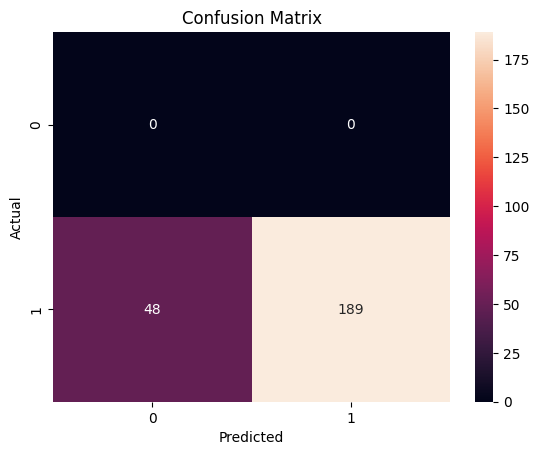

In [ ]:
# Evaluate using sklearn metrics
report = classification_report(df_test["binary_gold"], df_test["binary_prediction"], target_names=["Incorrect", "Correct"])
print("\nEvaluation Metrics:")
print(report)

print("\nConfusion Matrix:")
cm = confusion_matrix(df_test["binary_gold"], df_test["binary_prediction"])
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data from the table
data = {
    "Model": ["GPT-4o-mini", "GPT-4o-mini", "GPT-3.5-turbo", "GPT-4o-mini", "GPT-3.5-turbo",
              "GPT-4o-mini", "GPT-4o-mini", "GPT-3.5-turbo", "GPT-4o-mini", "GPT-3.5-turbo"],
    "Persona": ["FALSE", "FALSE", "FALSE", "TRUE", "TRUE",
                "FALSE", "FALSE", "FALSE", "TRUE", "TRUE"],
    "Style": ["Parallel", "Parallel", "Parallel", "Parallel", "Parallel",
              "Sequential", "Sequential", "Sequential", "Sequential", "Sequential"],
    "Accuracy": [0.71, 0.78, 0.8, 0.72, 0.73, 0.68, 0.73, 0.81, 0.79, 0.83],
    "F1 Score": [0.42, 0.44, 0.44, 0.42, 0.44, 0.4, 0.42, 0.45, 0.44, 0.45]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Set a custom Seaborn style and color palette
sns.set(style="whitegrid")
custom_palette = ["#f6ae2d", "#758e4f"]  # Custom blue and green colors

# Grouped Bar Plot for Accuracy and F1 Score
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Accuracy Bar Plot with Thinner Bars
sns.barplot(data=df, x="Model", y="Accuracy", hue="Persona", palette=custom_palette, ax=axes[0], width=0.4)
axes[0].set_title("Accuracy by Model and Persona")
axes[0].set_ylabel("Accuracy Score")
axes[0].set_xlabel("Model")
axes[0].legend(title="Persona", loc="best")

# F1 Score Bar Plot with Thinner Bars
sns.barplot(data=df, x="Model", y="F1 Score", hue="Persona", palette=custom_palette, ax=axes[1], width=0.4)
axes[1].set_title("F1 Score by Model and Persona")
axes[1].set_ylabel("F1 Score")
axes[1].set_xlabel("Model")
axes[1].legend(title="Persona", loc="best")

plt.tight_layout()
plt.show()
